# Time-Varying Cox Proportional Hazards Model for PyMc/PyTensor

In [1]:
import numpy as np
import pandas as pd

import pytensor.tensor as pt
import pymc as pm
import arviz  as az

import matplotlib.pyplot as plt
from lifelines.datasets import load_stanford_heart_transplants

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


numpy==1.26.4
pandas==2.2.3
pymc==5.19.1
arviz==0.20.0


I am going to assume familiarity with both survival analysis and pymc. There are great outlines for both elsewhere.

The form of cox ph, while known, is specified as such :

For the approximation for an individual to Survive to time 't', with explanatory variables 'X' and model weights 'beta':

$$Survial(t) =  BaseSurvial(t)^\left(exp(X \cdot beta)\right)$$

Hazard is defined as:

$$Hazard(t) =  BaseHazard(t)\left(exp(X \cdot beta)\right)$$



For the 'Breslow base hazard' for time 't': weights as 'beta', death/events at time t as 'e_t', and an array of explanatory variables for individuals who have not been censored or who have not experienced the event as X_t


$$BaseHazard(t) = \dfrac{e_t}{\left(exp(\sum_{}{}X_t×beta)\right)}$$

Base Survival is defined in relation to Base Hazard

$$BaseSurvial(t) = exp( - \sum_{1}^{t} BaseHazard(t)) $$



The Breslow estimator is explained is the following paper: Hanley JA. The Breslow estimator of the nonparametric baseline survivor function in Cox's regression model: some heuristics. Epidemiology. 2008 Jan;19(1):101-2. doi: 10.1097/EDE.0b013e31815be045. PMID: 18091419.


## Loading and transformation of data

Ok, let's start with loading the data.

It should be noted that I have purposely chosen a data set with left censoring and 'time-varying effects'.

The ability to left-censor data allows us to model variables that change over time for individuals and to capture recurrent events, in addition to allowing us to model individuals outside of literal 'age'.

In [3]:
data_df = load_stanford_heart_transplants()

data_df

,start,stop,event,age,year,surgery,transplant,id
0,0.0,50.0,1,-17.155373,0.123203,0,0,1
1,0.0,6.0,1,3.835729,0.254620,0,0,2
2,0.0,1.0,0,6.297057,0.265572,0,0,3
3,1.0,16.0,1,6.297057,0.265572,0,1,3
4,0.0,36.0,0,-7.737166,0.490075,0,0,4
...,...,...,...,...,...,...,...,...
167,0.0,38.0,0,-12.939083,6.395619,1,0,100
168,38.0,39.0,0,-12.939083,6.395619,1,1,100
169,0.0,31.0,0,1.516769,6.417522,0,0,101
170,0.0,11.0,0,-7.608487,6.472279,0,0,102


In [4]:
time_start = data_df['start'].values
time_end = data_df['stop'].values
event = data_df['event'].values

ids = data_df['id']

labes = ['age','year','surgery','transplant']

X_raw = data_df[labes]

In [5]:
all_times = np.hstack([time_start,time_end])
unique_times , unique_times_return_inverse =   np.unique(all_times, return_inverse=True)

time_end_return_inverse = unique_times_return_inverse[len(time_end):]
failure_per_unique_time = np.bincount(time_end_return_inverse, event, minlength = len(unique_times) )

Just a quick visualization of deaths and censorships over time

The code in the box below is irrelevant to our model, its just for the graph.

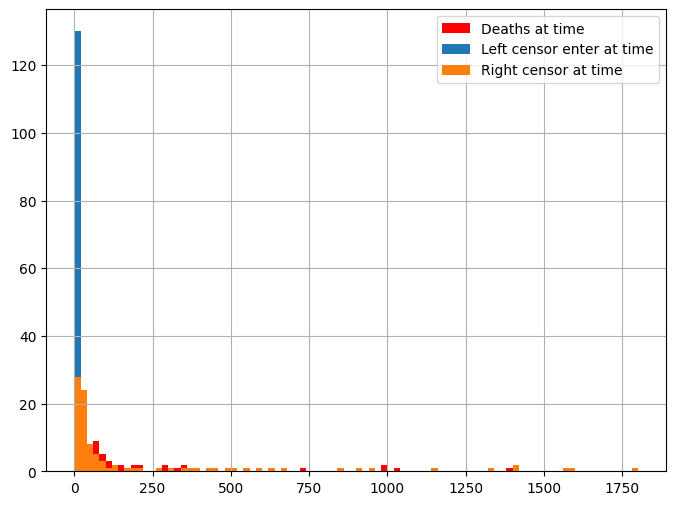

In [6]:
time_start_return_inverse = unique_times_return_inverse[:len(time_start)]
starts_per_time = np.bincount(time_start_return_inverse , minlength = len(unique_times) )
right_censor_per_time = np.bincount(time_end_return_inverse ,-(event - 1) ,minlength = len(unique_times) )


fig, ax = plt.subplots(figsize=(8, 6))

bins =int(max(unique_times)/20)

plt.hist(unique_times, weights=failure_per_unique_time, bins=bins, label='Deaths at time',stacked=True,color='red')
plt.hist(unique_times, weights=starts_per_time, bins=bins, label='Left censor enter at time',stacked=True)
plt.hist(unique_times, weights=right_censor_per_time, bins=bins, label='Right censor at time',stacked=True)

#plt.hist(unique_times, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.grid()
plt.show()



## Survival array representation

The get_survival_events should create an array that we will be using as the supervised vector for our model. After all, we observe survival in the real world.

In [ ]:
def get_survival_events(time_end:np.array,unique_times:np.array) -> np.array:
    unique_times =   np.sort(unique_times)
    unique_times_to_index_map = dict(zip(unique_times, range(len(unique_times))))
    number_of_unique_times =  len(unique_times)
    number_of_rows = len(time_end)

    survival = np.zeros((number_of_rows,number_of_unique_times))

    for i, v in enumerate(time_end):
        ti = unique_times_to_index_map[v]
        survival[i,:ti+1] = 1.0

    return survival

In [ ]:
survival_events = get_survival_events(time_end,unique_times) 

For each row, column, the individual associated with that row was known to have survived if the value is '1'

'0' means the associated individual was censored or experienced the failure event.

It should be mentioned that Cox PH does not care about steps in time that had no 'deaths' or censorships, looking at the columns, it should be obvious that some steps in time are skipped.

In [ ]:
pd.DataFrame(survival_events,columns=unique_times.astype(np.int64))

,0,1,2,3,4,4,5,6,8,9,...,996,1032,1142,1322,1387,1401,1408,1572,1587,1800
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Censorship array repsesation

I have code here for generating an array mask array for non-censored events. This mask array is used alongside the survival_events array above in the generation of the Breslow base hazard, as well as for masking off unwanted probabilities that we don't want to hand off to the mcmc sampler.

The 'Partial Likelihood' loss function for Cox PHh ignores values that are censored. Ie: if an individual survives to time x, but is then censored. For times until x, the explanatory variables associated with that individual contribute to a higher survival. During times of censorship, the loss function ignores the explanatory variables of censored individuals/rows.

In [10]:
def get_noncensored_mask(time_start:np.array,time_end:np.array ,event: np.ndarray, unique_times)-> np.ndarray:
    unique_times_to_index_map = dict(zip(unique_times, range(len(unique_times))))
    number_of_unique_times =  len(unique_times)
    number_of_rows = len(time_start)
        
    non_censor_mask = np.ones((number_of_rows,number_of_unique_times))
        
    for i, (ts,te, s) in enumerate(zip(time_start,time_end,event)):
        if not s:
            tei = unique_times_to_index_map[te]
            non_censor_mask[i,tei+1:] = 0
        tsi = unique_times_to_index_map[ts]
        non_censor_mask[i,:tsi] = 0
         
    return non_censor_mask.astype(np.bool_)

In [11]:
noncensored_mask = get_noncensored_mask(time_start,time_end ,event, unique_times)

Like the previous array, each columns represents relevent times. True means that that row was not censored at that given time

In [12]:
noncensored_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

## Breslow base hazard pytensor implementation


To get the Breslow base hazard, we will need to know which values are at 'risk' at any given time.
'At risk' being values are known to have been 'alive' at that time, and not censored.

To get this we simply multiply Noncensored values(1 if Noncensored, 0 if censored) and  our survival events (1 if survived, 0 if not survived)
Only values that have both survived and are not censored will still be 1.

\begin{equation}
  NonCensoredMask=\begin{cases}
    1, & \text{Not censored}.\\
    0, & \text{censored}.
  \end{cases}
\end{equation}


\begin{equation}
  SurvivalEvents=\begin{cases}
    1, & \text{survived}.\\
    0, & \text{not survived}.
  \end{cases}
\end{equation}

In [ ]:
rows_at_risk_at_time =  np.multiply( noncensored_mask, survival_events)

We are first getting the 'risk' as the exponential of the product of features and weights. 

A dot product between 'rows_at_risk_at_time' and 'risk' gives us the sum of risk present at each time. The 1's in the rows_at_risk_at_time keep the values present at that time and 0 remove values before summing them.

From there a simple division between 'deaths per time' and 'risk per time' gives us the Breslow base hazard. The Breslow base hazard is the inverse proposition of risk, according to our model weights, and deaths at a given time. Hanley has drawn parallels to Breslow Base Hazard and the Kaplan–Meier estimator.

Simply passing in the data and beta pytensor arrays into this function and using its output will update our pytensor graph with all the information it needs. The simplicity of this function should not be taken for granted, it has taken much trial and error to get it to be both vectorized and correct.

In [ ]:
def get_breslow_base_hazard(X: pt.TensorType,
                            beta: pt.TensorType,
                            rows_at_risk_at_time: np.array,
                            failure_per_unique_time: np.array,
                            ) -> pt.TensorType:

    risk = pt.exp(pt.dot(X,beta))
    risk_per_time = pt.dot(risk,rows_at_risk_at_time)
    base_hazard = failure_per_unique_time/risk_per_time
    return base_hazard


And the actual model. Nothing here should be surprising. This is all a literal implementation Cox PH as specified above. Using the base_survival as a base and risk as the power creats values that tend to hover between 0 and 1, perfect for a Bernoulli distributions.

In [ ]:
def normalize(X):
    return np.subtract(X , X.mean(axis=0))/X.std(axis=0)

X = normalize(X_raw)

with pm.Model(coords = {'labes': labes,'times':unique_times,'row_ids':ids }) as model:
    data = pm.Data("data", X,dims=('row_ids','labes'))

    beta = pm.Normal('beta',sigma=50,dims='labes')

    base_hazards = pm.Deterministic('base_hazard',get_breslow_base_hazard(data,beta,rows_at_risk_at_time,failure_per_unique_time))

    base_hazards_cumsum = base_hazards.cumsum()
    base_survival = np.exp(-base_hazards_cumsum)
    risk = pt.exp(pt.dot( data,beta))

    survival = base_survival ** risk[:, None]


Ok, here is where the magic happens. 

I am modeling survival as a series of Bernoulli distributions, each relevant step in time gets its a distribution. 

I am also removing probabilities that are censored(using the noncensored_mask). For this trick to work, I needed to fatten out the NxM array a log density probabilies, then mask off the log pdf's that are censored, and simply pass on the fattened and filtered log pdf's to the sampler. It turns out that the sampler does not care what shape the probability densities are.

In [ ]:
with model:
    def censored_bernoulli_logp(value,p,noncensored_mask):
        dis = pm.Bernoulli.logp(value,p= p)
        return dis.flatten()[noncensored_mask.flatten()]

    y = pm.DensityDist('y',survival,noncensored_mask,logp =censored_bernoulli_logp,observed=survival_events) 



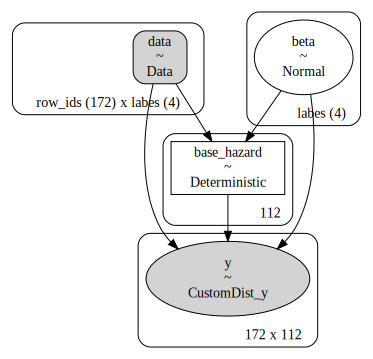

In [ ]:
model.to_graphviz()

Lets start sampeling!!!

In [ ]:
with model:
    trace = pm.sample(10000,tune=500,chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 121 seconds.


Looking good so far. I should warn you that the Nuts sampler will not always work with all datasets, I have had to sometimes had to revert to Metropolis. Feel free to tweak things to meet your needs.

In [ ]:
az.summary(trace,var_names=['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[age],0.303,0.017,0.271,0.335,0.0,0.0,44980.0,32934.0,1.0
beta[year],-0.210,0.017,-0.241,-0.178,0.0,0.0,60711.0,34003.0,1.0
beta[surgery],-0.283,0.020,-0.319,-0.245,0.0,0.0,52168.0,31777.0,1.0
beta[transplant],-0.498,0.018,-0.531,-0.465,0.0,0.0,48307.0,32769.0,1.0


array([[<Axes: title={'center': 'beta\nage'}>,
        <Axes: title={'center': 'beta\nage'}>],
       [<Axes: title={'center': 'beta\nyear'}>,
        <Axes: title={'center': 'beta\nyear'}>],
       [<Axes: title={'center': 'beta\nsurgery'}>,
        <Axes: title={'center': 'beta\nsurgery'}>],
       [<Axes: title={'center': 'beta\ntransplant'}>,
        <Axes: title={'center': 'beta\ntransplant'}>]], dtype=object)

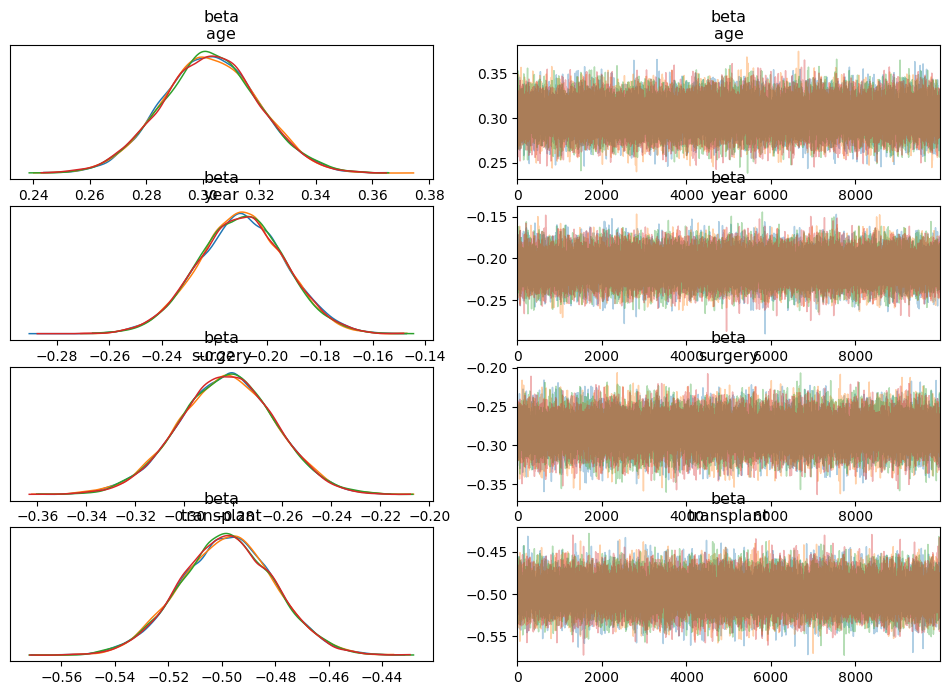

In [ ]:
az.plot_trace(trace,var_names=['beta'],compact=False)

I will leave proportional hazards assumption testing and stratification work for another time.